In [1]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 30.1 MB/s 
     |████████████████████████████████| 13.7 MB 80.2 MB/s 
     |████████████████████████████████| 120 kB 83.7 MB/s 
     |████████████████████████████████| 1.9 MB 76.1 MB/s 


In [4]:
import tensorflow as tf
import numpy as np
from sklearn import datasets as ds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import re
import csv
import random
import string
import multiprocessing
import itertools
import random
import csv
import statistics
import string
import random
import pennylane as qml

In [5]:
class SimplifiedDES(object):
    """Simplified DES is a simplified version of DES algorithm"""

    # Key size in bits
    key_size = 10

    """ Tables for initial and final permutations (b1, b2, b3, ... b8) """
    # Initial permutation
    IP_table = (2, 6, 3, 1, 4, 8, 5, 7)

    # Final permutation (Inverse of intial)
    FP_table = (4, 1, 3, 5, 7, 2, 8, 6)

    """ Tables for subkey generation (k1, k2, k3, ... k10) """
    P10_table = (3, 5, 2, 7, 4, 10, 1, 9, 8, 6)

    P8_table = (6, 3, 7, 4, 8, 5, 10, 9)

    """ Tables for the fk function """
    # Expansion permutation
    EP_table = (4, 1, 2, 3, 2, 3, 4, 1)

    # Substitution Box 0
    S0_table = (1, 0, 3, 2, 3, 2, 1, 0, 0, 2, 1, 3, 3, 1, 3, 2)

    # Substitution Box 1
    S1_table = (0, 1, 2, 3, 2, 0, 1, 3, 3, 0, 1, 0, 2, 1, 0, 3)

    # Permutation Table
    P4_table = (2, 4, 3, 1)

    def __init__(self, key):
        self.key = key
        self.subKey1, self.subKey2 = self.generate_key(self.key)

    def _perm(self, inputByte, permTable):
        """Permute input byte according to permutation table

        :param inputByte: byte to permute
        :param permTable: table to use for permutation
        :returns: permuted byte
        """
        outputByte = 0
        for index, elem in enumerate(permTable):
            if index >= elem:
                outputByte |= (inputByte & (128 >> (elem - 1))) >> (index - (elem - 1))
            else:
                outputByte |= (inputByte & (128 >> (elem - 1))) << ((elem - 1) - index)
        return outputByte

    def ip(self, inputByte):
        """Perform the initial permutation on data"""
        return self._perm(inputByte, self.IP_table)

    def fp(self, inputByte):
        """Perform the final permutation on data """
        return self._perm(inputByte, self.FP_table)

    def swap_nibbles(self, inputByte):
        """Swap the two nibbles of the byte """
        return (inputByte << 4 | inputByte >> 4) & 0xFF

    def left_shift(self, keyBitList):
        """Perform a circular left shift on the first and second set of five bits

        before = | 1| 2| 3| 4| 5| 6| 7| 8| 9|10|
        after  = | 2| 3| 4| 5| 1| 7| 8| 9|10| 6|

        :param keyBitList: list of bits
        :returns: circularly left shifted list of bits
        """
        shiftedKey = [None] * self.key_size
        shiftedKey[0:9] = keyBitList[1:10]
        shiftedKey[4] = keyBitList[0]
        shiftedKey[9] = keyBitList[5]

        return shiftedKey

    def generate_key(self, key):
        """Generate the two required subkeys

        K1 = P8(LS1(P10(key)))

        K2 = P8(LS2(LS1(P10(key))))

        :param key: key to be used for encryption and/or decryption
        :returns: tuple containing first subkey and second subkey
        """
        # Convert input key (integer) into a list of binary digits
        keyList = [(key & 1 << i) >> i for i in reversed(range(self.key_size))]

        # Initialise permuted key list to None
        permKeyList = [None] * self.key_size

        # To fill output of P10 permutation table and input
        for index, elem in enumerate(self.P10_table):

            # P10(key)
            permKeyList[index] = keyList[elem - 1]

        # LS1(P10(key))
        shiftedOnceKey = self.left_shift(permKeyList)

        # LS2(LS1(P10(key)))
        shiftedTwiceKey = self.left_shift(self.left_shift(shiftedOnceKey))

        subKey1 = subKey2 = 0
        for index, elem in enumerate(self.P8_table):

            # Apply P8() on first subkey
            subKey1 += (128 >> index) * shiftedOnceKey[elem - 1]

            # Apply P8() on second subkey
            subKey2 += (128 >> index) * shiftedTwiceKey[elem - 1]

        return (subKey1, subKey2)

    def F(self, sKey, rightNibble):
        """Round function
        1. Expansion Permutation Box
        2. XOR
        3. Substitution Boxes
        4. Permutation

        :param sKey: subkey to be used to for this round
        :param rightNibble: right nibble of the 8 bit input to this round
        :returns: 4 bit output
        """
        # Right nibble is permuted using EP and XOR'd with first key
        aux = sKey ^ self._perm(self.swap_nibbles(rightNibble), self.EP_table)

        # Find indices into the S-box S0
        index0 = (
            ((aux & 0x80) >> 4)
            + ((aux & 0x40) >> 5)
            + ((aux & 0x20) >> 5)
            + ((aux & 0x10) >> 2)
        )

        # Find indices into the S-box S1
        index1 = (
            ((aux & 0x08) >> 0)
            + ((aux & 0x04) >> 1)
            + ((aux & 0x02) >> 1)
            + ((aux & 0x01) << 2)
        )

        # S0(b1b2b3b4) = the [ b1b4 , b2b3 ] cell from the "S-box" S0
        # and similarly for S1
        sboxOutputs = self.swap_nibbles(
            (self.S0_table[index0] << 2) + self.S1_table[index1]
        )

        # Apply permutation
        return self._perm(sboxOutputs, self.P4_table)

    def fk(self, subKey, inputData):
        """Apply Feistel function on data with given subkey

        :param subKey: subkey to be used to for this round
        :param inputData: 8 bit input for this round
        :returns: 8 bit output
        """
        # Divide the permuted bits into 2 halves
        leftNibble = inputData & 0xF0
        rightNibble = inputData & 0x0F

        # Apply F
        FOutput = self.F(subKey, rightNibble)

        # Return left nibble and right nibble
        return (leftNibble ^ FOutput) | rightNibble

    def encrypt(self, plaintext):
        """Encrypt plaintext with given key

        ciphertext = IP^-1( fK2( SW( fK1( IP( plaintext ) ) ) ) )

        Example::

            ciphertext = SimplifiedDES(3).encrypt(0b10101111)

        :param plaintext: 8 bit plaintext
        :returns: 8 bit ciphertext
        """
        permuted_text = self.ip(plaintext)

        first_round_output = self.fk(self.subKey1, permuted_text)
        
        second_round_output = self.fk(
            self.subKey2, self.swap_nibbles(first_round_output)
        )
        

        return self.fp(second_round_output)

    def decrypt(self, ciphertext):
        """Decrypt ciphertext with given key

        plaintext = IP^-1( fK1( SW( fK2( IP( ciphertext ) ) ) ) )

        Example::

            plaintext = SimplifiedDES(3).decrypt(0b10101111)

        :param ciphertext: 8 bit ciphertext
        :returns: 8 bit plaintext
        """
        permuted_text = self.ip(ciphertext)

        first_round_output = self.fk(self.subKey2, permuted_text)

        second_round_output = self.fk(
            self.subKey1, self.swap_nibbles(first_round_output)
        )

        return self.fp(second_round_output)

In [6]:
import numpy as np
from os import urandom
import numpy as np
from os import urandom
import random

#convert_to_binary takes as input an array of ciphertext pairs
#where the first row of the array contains the lefthand side of the ciphertexts,
#the second row contains the righthand side of the ciphertexts,
#the third row contains the lefthand side of the second ciphertexts,
#and so on
#it returns an array of bit vectors containing the same data


def WORD_SIZE():
    return(4);
'''
def ALPHA():
    return(7);

def BETA():
    return(2);
'''

def convert_to_binary(arr):
  X = np.zeros((4 * WORD_SIZE(),len(arr[0])),dtype=np.uint8);
  for i in range(4 * WORD_SIZE()):
    index = i // WORD_SIZE();
    offset = WORD_SIZE() - (i % WORD_SIZE()) - 1;
    X[i] = (arr[index] >> offset) & 1;
  X = X.transpose();
  return(X);

#takes a text file that contains encrypted block0, block1, true diff prob, real or random
#data samples are line separated, the above items whitespace-separated
#returns train data, ground truth, optimal ddt prediction
def readcsv(datei):
    data = np.genfromtxt(datei, delimiter=' ', converters={x: lambda s: int(s,16) for x in range(2)});
    X0 = [data[i][0] for i in range(len(data))];
    X1 = [data[i][1] for i in range(len(data))];
    Y = [data[i][3] for i in range(len(data))];
    Z = [data[i][2] for i in range(len(data))];
    ct0a = [X0[i] >> 16 for i in range(len(data))];
    ct1a = [X0[i] & MASK_VAL for i in range(len(data))];
    ct0b = [X1[i] >> 16 for i in range(len(data))];
    ct1b = [X1[i] & MASK_VAL for i in range(len(data))];
    ct0a = np.array(ct0a, dtype=np.uint16); ct1a = np.array(ct1a,dtype=np.uint16);
    ct0b = np.array(ct0b, dtype=np.uint16); ct1b = np.array(ct1b, dtype=np.uint16);
    
    #X = [[X0[i] >> 16, X0[i] & 0xffff, X1[i] >> 16, X1[i] & 0xffff] for i in range(len(data))];
    X = convert_to_binary([ct0a, ct1a, ct0b, ct1b]); 
    Y = np.array(Y, dtype=np.uint8); Z = np.array(Z);
    return(X,Y,Z);

#baseline training data generator
def make_train_data(n, nr, diff=(0x9,0x6)):

  plain0l = np.zeros(shape=(n,),dtype=int)
  plain0r = np.zeros(shape=(n,),dtype=int)
  plain1l = np.zeros(shape=(n,),dtype=int)
  plain1r = np.zeros(shape=(n,),dtype=int)

  for i in range(n):
    plain0l[i] = random.randint(0, 15)
    plain0r[i] = random.randint(0, 15)

    plain1l[i] = plain0l[i] ^ diff[0];
    plain1r[i] = plain0r[i] ^ diff[1];

  Y = np.ones(shape=(n,)) # cipher

  for i in range(int(n/2)):
    #i 인덱스 부분만 다시 Random 채우기
    plain1l[i] = random.randint(0, 15)
    plain1r[i] = random.randint(0, 15)
    Y[i] = 0 # random 

 
  plain0 = np.zeros(shape=(n,),dtype=int)
  plain1 = np.zeros(shape=(n,),dtype=int)
  ctdata0 = np.zeros(shape=(n,),dtype=int)
  ctdata1 = np.zeros(shape=(n,),dtype=int)

  ctdata0r = np.zeros(shape=(n,),dtype=int)
  ctdata0l = np.zeros(shape=(n,),dtype=int)
  ctdata1r = np.zeros(shape=(n,),dtype=int)
  ctdata1l = np.zeros(shape=(n,),dtype=int)
  
  for i in range(n):
    plain0[i] = int(16*(plain0l[i]) + plain0r[i])
    plain1[i] = int(16*(plain1l[i]) + plain1r[i])

    ks = random.randint(0, 1023)
    
    ctdata0[i] = SimplifiedDES(ks).encrypt(plain0[i])
    ctdata1[i] = SimplifiedDES(ks).encrypt(plain1[i])

    ctdata0r[i] = ctdata0[i] % 16
    ctdata0l[i] = ctdata0[i] >> 4

    ctdata1r[i] = ctdata1[i] % 16
    ctdata1l[i] = ctdata1[i] >> 4

  X = convert_to_binary([ctdata0l, ctdata0r, ctdata1l, ctdata1r]);    # ct0l, ct0r 은 랜덤 , 그리고 ct1l, ct1r이 랜덤일 경우는 랜덤쌍, 랜덤 아니라 차분인 경우 차분 쌍이므로 훈련데이터셋 생성 완료


  return(X,Y);

In [7]:
num_rounds=2
x_train, y_train = make_train_data(1000,num_rounds); #10**7
x_val, y_val = make_train_data(200,num_rounds); #10**7
x_test, y_test = make_train_data(100,num_rounds); #10**7

x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)


y_train = y_train.reshape((len(y_train),1))
y_val = y_val.reshape((len(y_val),1))
y_test = y_test.reshape((len(y_test),1))

Basic

In [ ]:
import pennylane as qml

n_qubits = 2
dev = qml.device('qiskit.ibmq', wires=1, backend='ibmq_qasm_simulator', ibmqx_token="2d44b46106dc0f0ac0c4c6dbd929fa20687830c31a00ca1cde97e28e4d897af34e34d719f97e04db8313f28ec91922b1663f59be50795e586025955124eff17c")
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [ ]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 4

dev = qml.device("default.qubit", wires=n_qubits)
#dev = qml.device('qulacs.simulator', wires=n_qubits) 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), pad_with=0, normalize=True)
    qml.RandomLayers(weights=weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [21]:
#dev = qml.device('default.qubit', wires=4)
n_qubits = 4

dev = qml.device("default.mixed", wires=n_qubits)

#dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev) # , interface="tf", diff_method="backprop 
def qnode(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), pad_with=0, normalize=True)
    qml.StronglyEntanglingLayers(weights=weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [22]:
n_layers = 15
weight_shapes = {"weights": (n_layers, n_qubits,3)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

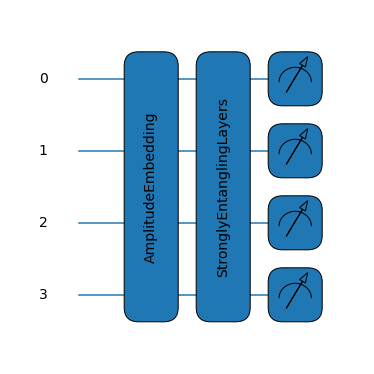

In [23]:
w = np.ones((n_layers, n_qubits,3))
inputssss = np.ones((32,16))
fig, ax = qml.draw_mpl(qnode)(inputssss,w)
fig.show()

In [28]:
# re-define the layers
clayer_1 = tf.keras.layers.Dense(16)
#clayer_2 = tf.keras.layers.Dense(128)
#clayer_3 = tf.keras.layers.Dense(64)
# qubit 수 * 양자회로 수 는 맞아야 함

q1 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
#q2 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
#q3 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
#q4 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

output_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')

# construct the model
inputs = tf.keras.Input(shape=(16,))
x = clayer_1(inputs)
#x = clayer_2(x)
#x = clayer_3(x)
#x1, x2, x3, x4 = tf.split(x, 4, axis=1)

x = q1(x)
#x2 = q2(x2)
#x3 = q3(x3)
#x4 = q4(x4)

#x = tf.concat([x1,x2,x3,x4], axis=1)
outputs = output_layer(x)

q1.build((32,16))
#q2.build((32,16))
#q3.build((32,16))
#q4.build((32,16))

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [29]:
model. summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_12 (Dense)            (None, 16)                272       
                                                                 
 keras_layer_18 (KerasLayer)  (None, 4)                180       
                                                                 
 dense_13 (Dense)            (None, 1)                 5         
                                                                 
Total params: 457
Trainable params: 457
Non-trainable params: 0
_________________________________________________________________


In [30]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(opt, loss="binary_crossentropy", metrics=["acc"])

In [ ]:
fitting = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data = (x_val, y_val), verbose=2)

Epoch 1/20


In [ ]:
predicted_labels = model.predict(np.array(x_test))

res = np.array(predicted_labels > 0.5, dtype = int)

res = res.reshape((len(x_test)))
y_test = y_test.reshape((len(y_test)))

total = 0

for i in range(len(res)):
    if res[i] == y_test[i]:
        total += 1

print(total/len(x_test))
